# Speech Emotion Recognition using CNN.

## Introduction

#### Human emotions play a key role in communication, and recognizing them automatically has many applications in healthcare, call centers, education, entertainment, and human computer interaction. For example, virtual assistants, customer support bots, and AI companions can respond more naturally if they understand a user’s emotional state.

#### This project focuses on Speech Emotion Recognition, where the goal is to classify emotions (such as happy, sad, angry, fearful, calm, disgust, surprised, neutral) from audio recordings.

#### To achieve this, I used the RAVDESS dataset (Ryerson Audio-Visual Database of Emotional Speech and Song), which contains thousands of speech samples spoken by professional actors in different emotional tones.

#### The approach involves:

#### Feature Extraction - using Mel-Frequency Cepstral Coefficients (MFCCs), a popular feature in speech processing.

#### Data Augmentation - applying techniques like noise injection, pitch shifting, and time-stretching to improve model robustness.

#### Deep Learning Model - training a Convolutional Neural Network (CNN) on MFCC spectrograms to detect patterns that correspond to different emotions.

#### Evaluation - assessing performance using accuracy, precision, recall, F1-score, and a confusion matrix.

#### By the end of this project, we obtain a trained deep learning model capable of predicting emotions from speech. The trained model is also integrated into a Streamlit web app, allowing users to upload .wav files and get instant emotion predictions.

In [1]:
# Import Libraries
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import pickle


In [3]:
# Augmentation Functions
def add_noise(data, noise_factor=0.02):
    noise = np.random.randn(len(data))
    return data + noise_factor * noise

def change_pitch(data, sampling_rate, pitch_factor=2):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def change_speed(data, speed_factor=1.2):
    return librosa.effects.time_stretch(data, rate=speed_factor)

def pad_or_truncate(mfccs, max_pad_len):
    if mfccs.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    return mfccs

In [5]:
# Feature Extraction

def extract_features(file_path, max_pad_len=174, augment=False):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    features = []
    
    # Original
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    features.append(pad_or_truncate(mfccs, max_pad_len))
    
    if augment:
        # Noise
        noise_audio = add_noise(audio)
        mfccs = librosa.feature.mfcc(y=noise_audio, sr=sample_rate, n_mfcc=40)
        features.append(pad_or_truncate(mfccs, max_pad_len))

        # Pitch shift
        pitch_audio = change_pitch(audio, sample_rate)
        mfccs = librosa.feature.mfcc(y=pitch_audio, sr=sample_rate, n_mfcc=40)
        features.append(pad_or_truncate(mfccs, max_pad_len))

        # Speed change
        try:
            speed_audio = change_speed(audio)
            mfccs = librosa.feature.mfcc(y=speed_audio, sr=sample_rate, n_mfcc=40)
            features.append(pad_or_truncate(mfccs, max_pad_len))
        except:
            pass 
    
    return features

In [7]:
# Load Dataset
emotions = {
    '01':'neutral', '02':'calm', '03':'happy', '04':'sad',
    '05':'angry', '06':'fearful', '07':'disgust', '08':'surprised'
}

X, y = [], []
dataset_path = r"C:\Users\USER\Downloads\Emotional_Speech_Recognition\audio_speech_actors_01-24"

for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    if os.path.isdir(actor_path):
        for file in tqdm(os.listdir(actor_path), desc=f"Processing {actor_folder}"):
            if file.endswith(".wav"):
                file_path = os.path.join(actor_path, file)
                emotion = emotions[file.split("-")[2]]
                features = extract_features(file_path, augment=True)  # Augment here
                for feat in features:
                    X.append(feat)
                    y.append(emotion)

X = np.array(X)
y = np.array(y)

print("Features shape:", X.shape)
print("Labels shape:", y.shape)


Processing Actor_24: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:24<00:00,  2.48it/s]


Features shape: (5760, 40, 174)
Labels shape: (5760,)


In [9]:
# Preprocess Data
# Encode labels
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))

# Save label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# Reshape X for CNN
X = X[..., np.newaxis]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Compute class weights
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.9381107491856677), 1: np.float64(0.9365853658536586), 2: np.float64(0.9381107491856677), 3: np.float64(0.9381107491856677), 4: np.float64(0.9381107491856677), 5: np.float64(1.8762214983713354), 6: np.float64(0.9365853658536586), 7: np.float64(0.9365853658536586)}


In [13]:
from tensorflow.keras import Input

# Build CNN Model (Warning-Free)
model = Sequential([
    Input(shape=(40,174,1)),                 # 👈 Explicit Input layer
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 38, 172, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 17, 84, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 21504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,752,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,772,488 (10.58 MB)

 Trainable params: 2,772,488 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    class_weight=class_weights,   # balance training
    verbose=1
)


Epoch 1/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 27s 160ms/step - accuracy: 0.1528 - loss: 12.4199 - val_accuracy: 0.2023 - val_loss: 1.9659
Epoch 2/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.2056 - loss: 1.9649 - val_accuracy: 0.2170 - val_loss: 1.8981
Epoch 3/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.2669 - loss: 1.8465 - val_accuracy: 0.3368 - val_loss: 1.7448
Epoch 4/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.3060 - loss: 1.7697 - val_accuracy: 0.3177 - val_loss: 1.7421
Epoch 5/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 0.3315 - loss: 1.7296 - val_accuracy: 0.3672 - val_loss: 1.6457
Epoch 6/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 0.3567 - loss: 1.6753 - val_accuracy: 0.3967 - val_loss: 1.5968
Epoch 7/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.3808 - loss: 1.5883 - val_accuracy: 0.3550 - val_loss: 1.6350
Epoch 8/40
144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.4010 - loss: 

✅ Test Accuracy: 64.93%


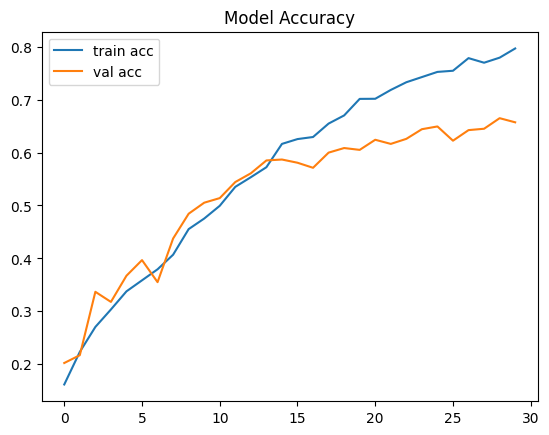

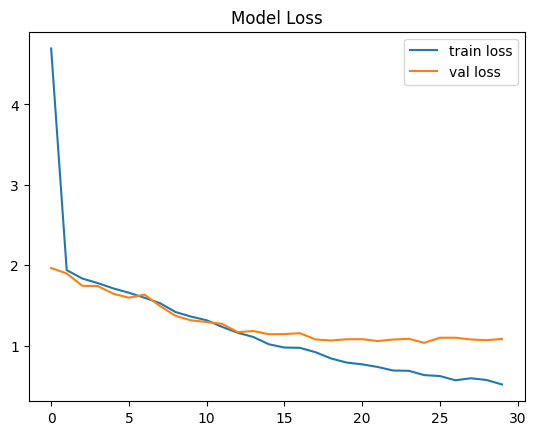

In [17]:
# Evaluate Model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

# Plot training curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model Loss")
plt.show()


In [21]:

from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build Improved CNN
model = Sequential([
    Input(shape=(40,174,1)),

    # First Block
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # Second Block
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # Third Block (extra layer)
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 38, 172, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 38, 172, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 84, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 17, 84, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 40, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 40, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 3, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       1,966,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,061,960 (7.87 MB)

 Trainable params: 2,061,512 (7.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    "best_emotion_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=50,   
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.1953 - loss: 3.6470
Epoch 1: val_accuracy improved from -inf to 0.26302, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 35s 226ms/step - accuracy: 0.1954 - loss: 3.6387 - val_accuracy: 0.2630 - val_loss: 1.8983
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.2894 - loss: 1.8220
Epoch 2: val_accuracy improved from 0.26302 to 0.35243, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.2894 - loss: 1.8220 - val_accuracy: 0.3524 - val_loss: 1.7017
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.3121 - loss: 1.7350
Epoch 3: val_accuracy improved from 0.35243 to 0.36545, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - accuracy: 0.3122 - loss: 1.7349 - val_accuracy: 0.3655 - val_loss: 1.5764
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3466 - loss: 1.6553
Epoch 4: val_accuracy improved from 0.36545 to 0.40017, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 35s 242ms/step - accuracy: 0.3466 - loss: 1.6553 - val_accuracy: 0.4002 - val_loss: 1.5511
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.3992 - loss: 1.5516
Epoch 5: val_accuracy improved from 0.40017 to 0.44878, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 249ms/step - accuracy: 0.3992 - loss: 1.5516 - val_accuracy: 0.4488 - val_loss: 1.4349
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.4300 - loss: 1.4741
Epoch 6: val_accuracy did not improve from 0.44878
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - accuracy: 0.4301 - loss: 1.4741 - val_accuracy: 0.4436 - val_loss: 1.4865
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.4672 - loss: 1.3566
Epoch 7: val_accuracy improved from 0.44878 to 0.50955, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 34s 238ms/step - accuracy: 0.4673 - loss: 1.3566 - val_accuracy: 0.5095 - val_loss: 1.2930
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.4965 - loss: 1.2860
Epoch 8: val_accuracy improved from 0.50955 to 0.51997, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - accuracy: 0.4965 - loss: 1.2861 - val_accuracy: 0.5200 - val_loss: 1.3236
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.5363 - loss: 1.1975
Epoch 9: val_accuracy improved from 0.51997 to 0.53733, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 246ms/step - accuracy: 0.5362 - loss: 1.1976 - val_accuracy: 0.5373 - val_loss: 1.2459
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5568 - loss: 1.1150
Epoch 10: val_accuracy improved from 0.53733 to 0.54080, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 248ms/step - accuracy: 0.5568 - loss: 1.1152 - val_accuracy: 0.5408 - val_loss: 1.2647
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5829 - loss: 1.0912
Epoch 11: val_accuracy improved from 0.54080 to 0.58333, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - accuracy: 0.5829 - loss: 1.0912 - val_accuracy: 0.5833 - val_loss: 1.1349
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.6140 - loss: 0.9752
Epoch 12: val_accuracy improved from 0.58333 to 0.60243, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - accuracy: 0.6140 - loss: 0.9754 - val_accuracy: 0.6024 - val_loss: 1.1102
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.6395 - loss: 0.9378
Epoch 13: val_accuracy improved from 0.60243 to 0.61806, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 258ms/step - accuracy: 0.6395 - loss: 0.9379 - val_accuracy: 0.6181 - val_loss: 1.0684
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6418 - loss: 0.9033
Epoch 14: val_accuracy improved from 0.61806 to 0.63281, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 253ms/step - accuracy: 0.6418 - loss: 0.9034 - val_accuracy: 0.6328 - val_loss: 1.0902
Epoch 15/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.6928 - loss: 0.8145
Epoch 15: val_accuracy did not improve from 0.63281
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.6928 - loss: 0.8145 - val_accuracy: 0.6328 - val_loss: 1.0982
Epoch 16/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7094 - loss: 0.7671
Epoch 16: val_accuracy improved from 0.63281 to 0.64844, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 270ms/step - accuracy: 0.7094 - loss: 0.7672 - val_accuracy: 0.6484 - val_loss: 1.0691
Epoch 17/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7266 - loss: 0.7098
Epoch 17: val_accuracy did not improve from 0.64844
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 260ms/step - accuracy: 0.7265 - loss: 0.7101 - val_accuracy: 0.6354 - val_loss: 1.0898
Epoch 18/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7400 - loss: 0.6794
Epoch 18: val_accuracy improved from 0.64844 to 0.65451, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.7399 - loss: 0.6795 - val_accuracy: 0.6545 - val_loss: 1.1107
Epoch 19/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7494 - loss: 0.6641
Epoch 19: val_accuracy improved from 0.65451 to 0.66667, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 262ms/step - accuracy: 0.7493 - loss: 0.6641 - val_accuracy: 0.6667 - val_loss: 1.0557
Epoch 20/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7732 - loss: 0.5741
Epoch 20: val_accuracy did not improve from 0.66667
144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - accuracy: 0.7731 - loss: 0.5743 - val_accuracy: 0.6658 - val_loss: 1.0932
Epoch 21/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7756 - loss: 0.5988
Epoch 21: val_accuracy improved from 0.66667 to 0.69097, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 264ms/step - accuracy: 0.7756 - loss: 0.5988 - val_accuracy: 0.6910 - val_loss: 1.0272
Epoch 22/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7879 - loss: 0.5659
Epoch 22: val_accuracy improved from 0.69097 to 0.69618, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 250ms/step - accuracy: 0.7878 - loss: 0.5660 - val_accuracy: 0.6962 - val_loss: 0.9886
Epoch 23/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8004 - loss: 0.5226
Epoch 23: val_accuracy did not improve from 0.69618
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 255ms/step - accuracy: 0.8003 - loss: 0.5227 - val_accuracy: 0.6884 - val_loss: 1.1049
Epoch 24/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8101 - loss: 0.5053
Epoch 24: val_accuracy improved from 0.69618 to 0.71007, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 262ms/step - accuracy: 0.8101 - loss: 0.5052 - val_accuracy: 0.7101 - val_loss: 1.0464
Epoch 25/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8215 - loss: 0.4683
Epoch 25: val_accuracy did not improve from 0.71007
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - accuracy: 0.8215 - loss: 0.4683 - val_accuracy: 0.6944 - val_loss: 1.0485
Epoch 26/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8416 - loss: 0.4350
Epoch 26: val_accuracy did not improve from 0.71007
144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - accuracy: 0.8415 - loss: 0.4351 - val_accuracy: 0.7040 - val_loss: 1.0333
Epoch 27/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8429 - loss: 0.4056
Epoch 27: val_accuracy improved from 0.71007 to 0.71094, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 260ms/step - accuracy: 0.8428 - loss: 0.4057 - val_accuracy: 0.7109 - val_loss: 0.9753
Epoch 28/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.8513 - loss: 0.3971
Epoch 28: val_accuracy improved from 0.71094 to 0.71875, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 35s 243ms/step - accuracy: 0.8512 - loss: 0.3972 - val_accuracy: 0.7188 - val_loss: 1.0220
Epoch 29/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.8535 - loss: 0.3888
Epoch 29: val_accuracy did not improve from 0.71875
144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - accuracy: 0.8535 - loss: 0.3888 - val_accuracy: 0.6910 - val_loss: 1.0899
Epoch 30/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8628 - loss: 0.3805
Epoch 30: val_accuracy did not improve from 0.71875
144/144 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step - accuracy: 0.8628 - loss: 0.3805 - val_accuracy: 0.7005 - val_loss: 1.0517
Epoch 31/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8619 - loss: 0.3870
Epoch 31: val_accuracy did not improve from 0.71875
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.8619 - loss: 0.3868 - val_accuracy: 0.7135 - val_loss: 1.0230
Epoch 32/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8820 - loss: 0.3066
Epoch 32

144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 256ms/step - accuracy: 0.8820 - loss: 0.3067 - val_accuracy: 0.7361 - val_loss: 0.9499
Epoch 33/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8693 - loss: 0.3535
Epoch 33: val_accuracy improved from 0.73611 to 0.73872, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 256ms/step - accuracy: 0.8693 - loss: 0.3535 - val_accuracy: 0.7387 - val_loss: 0.9529
Epoch 34/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.8902 - loss: 0.3011
Epoch 34: val_accuracy did not improve from 0.73872
144/144 ━━━━━━━━━━━━━━━━━━━━ 35s 243ms/step - accuracy: 0.8901 - loss: 0.3013 - val_accuracy: 0.7222 - val_loss: 1.0974
Epoch 35/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8869 - loss: 0.2880
Epoch 35: val_accuracy improved from 0.73872 to 0.74479, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - accuracy: 0.8869 - loss: 0.2880 - val_accuracy: 0.7448 - val_loss: 0.9922
Epoch 36/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8919 - loss: 0.3046
Epoch 36: val_accuracy improved from 0.74479 to 0.74740, saving model to best_emotion_model.h5


144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 273ms/step - accuracy: 0.8919 - loss: 0.3045 - val_accuracy: 0.7474 - val_loss: 0.9756
Epoch 37/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9089 - loss: 0.2492
Epoch 37: val_accuracy did not improve from 0.74740
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 257ms/step - accuracy: 0.9088 - loss: 0.2494 - val_accuracy: 0.7387 - val_loss: 1.1323
Epoch 38/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8945 - loss: 0.2883
Epoch 38: val_accuracy did not improve from 0.74740
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 272ms/step - accuracy: 0.8945 - loss: 0.2884 - val_accuracy: 0.7474 - val_loss: 1.0232
Epoch 39/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9037 - loss: 0.2852
Epoch 39: val_accuracy did not improve from 0.74740
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 260ms/step - accuracy: 0.9037 - loss: 0.2853 - val_accuracy: 0.7396 - val_loss: 1.0144


 Test Accuracy: 73.61%
 Test Loss: 0.9499


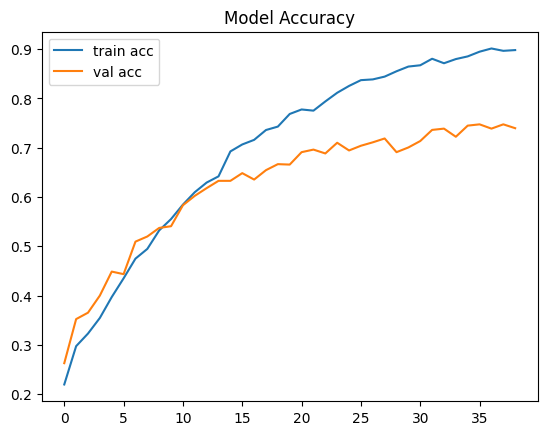

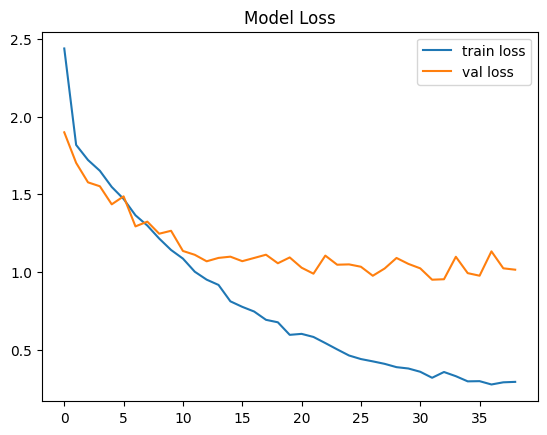

In [25]:
# Re-Evaluate Model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f" Test Accuracy: {acc*100:.2f}%")
print(f" Test Loss: {loss:.4f}")

# Plot training curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model Loss")
plt.show()

## CNN with Data Augmentation + Class Weights so we can push accuracy higher 

In [28]:
# ADD AUGMENTATION FUNCTION
def add_noise(data, noise_factor=0.02):
    noise = np.random.randn(len(data))
    return data + noise_factor * noise

def shift_time(data, sampling_rate):
    shift = np.random.randint(sampling_rate)
    return np.roll(data, shift)

def change_pitch(data, sampling_rate, pitch_factor=2):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def change_speed(data, speed_factor=1.2):
    return librosa.effects.time_stretch(data, rate=speed_factor)


In [30]:
# Modify feature extraction
def extract_features(file_path, max_pad_len=174, augment=False):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    
    features = []
    # Original
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    features.append(pad_or_truncate(mfccs, max_pad_len))
    
    if augment:
        # Noise
        noise_audio = add_noise(audio)
        mfccs = librosa.feature.mfcc(y=noise_audio, sr=sample_rate, n_mfcc=40)
        features.append(pad_or_truncate(mfccs, max_pad_len))

        # Pitch shift
        pitch_audio = change_pitch(audio, sample_rate)
        mfccs = librosa.feature.mfcc(y=pitch_audio, sr=sample_rate, n_mfcc=40)
        features.append(pad_or_truncate(mfccs, max_pad_len))

        # Speed change
        speed_audio = change_speed(audio)
        mfccs = librosa.feature.mfcc(y=speed_audio, sr=sample_rate, n_mfcc=40)
        features.append(pad_or_truncate(mfccs, max_pad_len))
    
    return features

def pad_or_truncate(mfccs, max_pad_len):
    if mfccs.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    return mfccs


In [32]:
#Apply during dataset loading
X, y = [], []

for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)
    if os.path.isdir(actor_path):
        for file in tqdm(os.listdir(actor_path), desc=f"Processing {actor_folder}"):
            if file.endswith(".wav"):
                file_path = os.path.join(actor_path, file)
                emotion = emotions[file.split("-")[2]]
                
                features = extract_features(file_path, augment=True)
                for feat in features:
                    X.append(feat)
                    y.append(emotion)

X = np.array(X)
y = np.array(y)


Processing Actor_24: 100%|█████████████████████████████████████████████████████████████| 60/60 [00:13<00:00,  4.44it/s]


In [36]:
#Add class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.9375), 1: np.float64(0.9375), 2: np.float64(0.9375), 3: np.float64(0.9375), 4: np.float64(0.9375), 5: np.float64(1.875), 6: np.float64(0.9375), 7: np.float64(0.9375)}


In [38]:
#Train with Augmentation + Class Weights
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,   
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8772 - loss: 0.3601
Epoch 1: val_accuracy did not improve from 0.74740
144/144 ━━━━━━━━━━━━━━━━━━━━ 33s 219ms/step - accuracy: 0.8772 - loss: 0.3600 - val_accuracy: 0.7161 - val_loss: 1.0772
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8790 - loss: 0.3467
Epoch 2: val_accuracy did not improve from 0.74740
144/144 ━━━━━━━━━━━━━━━━━━━━ 32s 219ms/step - accuracy: 0.8790 - loss: 0.3468 - val_accuracy: 0.7014 - val_loss: 1.0852
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8820 - loss: 0.3350
Epoch 3: val_accuracy did not improve from 0.74740
144/144 ━━━━━━━━━━━━━━━━━━━━ 61s 359ms/step - accuracy: 0.8820 - loss: 0.3350 - val_accuracy: 0.7231 - val_loss: 1.0927
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8965 - loss: 0.2905
Epoch 4: val_accuracy did not improve from 0.74740
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 320ms/step - accuracy: 0.8964 - loss: 0.2906 - val_

144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 318ms/step - accuracy: 0.9136 - loss: 0.2553 - val_accuracy: 0.7535 - val_loss: 1.1115
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9238 - loss: 0.2269
Epoch 12: val_accuracy did not improve from 0.75347
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 317ms/step - accuracy: 0.9238 - loss: 0.2269 - val_accuracy: 0.7439 - val_loss: 1.1300
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9136 - loss: 0.2445
Epoch 13: val_accuracy did not improve from 0.75347
144/144 ━━━━━━━━━━━━━━━━━━━━ 46s 319ms/step - accuracy: 0.9137 - loss: 0.2445 - val_accuracy: 0.7387 - val_loss: 1.0761
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9174 - loss: 0.2287
Epoch 14: val_accuracy did not improve from 0.75347
144/144 ━━━━━━━━━━━━━━━━━━━━ 47s 323ms/step - accuracy: 0.9173 - loss: 0.2287 - val_accuracy: 0.7517 - val_loss: 1.0279


 Test Accuracy: 74.13%
 Test Loss: 1.0175


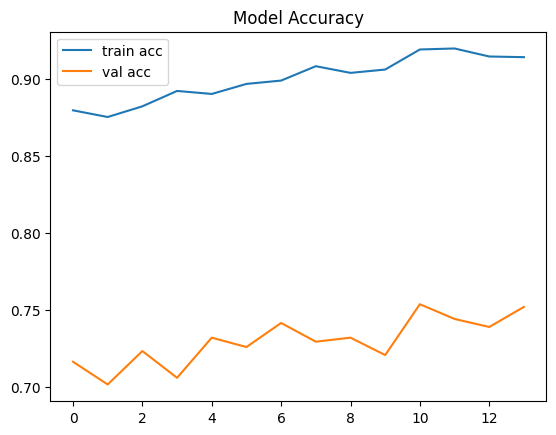

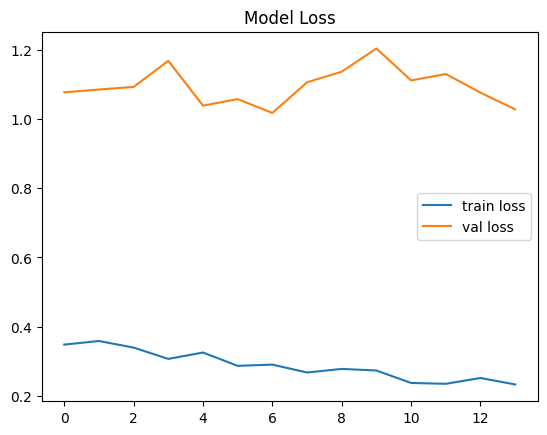

In [40]:
# Re-Evaluate Model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f" Test Accuracy: {acc*100:.2f}%")
print(f" Test Loss: {loss:.4f}")

# Plot training curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model Loss")
plt.show()

## CNN+LSTM Model for a more improved accuracy

In [47]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Reshape, LSTM, Dense

model = Sequential([
    Input(shape=(40,174,1)),

    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # Reshape for LSTM
    Reshape((-1, 64)),   

    LSTM(128, return_sequences=False),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 38, 172, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 38, 172, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 17, 84, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 17, 84, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 336, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,560 (529.53 KB)

 Trainable params: 135,368 (528.78 KB)

 Non-trainable params: 192 (768.00 B)

In [49]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,  
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.1436 - loss: 2.0802
Epoch 1: val_accuracy did not improve from 0.75347
144/144 ━━━━━━━━━━━━━━━━━━━━ 66s 436ms/step - accuracy: 0.1437 - loss: 2.0801 - val_accuracy: 0.1944 - val_loss: 1.9807
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.2105 - loss: 1.9567
Epoch 2: val_accuracy did not improve from 0.75347
144/144 ━━━━━━━━━━━━━━━━━━━━ 56s 389ms/step - accuracy: 0.2107 - loss: 1.9565 - val_accuracy: 0.2943 - val_loss: 1.8227
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.2716 - loss: 1.8383
Epoch 3: val_accuracy did not improve from 0.75347
144/144 ━━━━━━━━━━━━━━━━━━━━ 57s 395ms/step - accuracy: 0.2715 - loss: 1.8383 - val_accuracy: 0.3073 - val_loss: 1.8010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.2879 - loss: 1.7833
Epoch 4: val_accuracy did not improve from 0.75347
144/144 ━━━━━━━━━━━━━━━━━━━━ 80s 379ms/step - accuracy: 0.2880 - loss: 1.7833 - val_

In [51]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f" CNN+LSTM Test Accuracy: {acc*100:.2f}%")
print(f" CNN+LSTM Test Loss: {loss:.4f}")


 CNN+LSTM Test Accuracy: 58.94%
 CNN+LSTM Test Loss: 1.1818


## Although I experimented with a hybrid CNN+LSTM architecture to capture temporal dependencies in the speech signal, the performance dropped significantly (59% accuracy) compared to my CNN baseline (74%). This is likely due to the relatively small size of the RAVDESS dataset, which makes training LSTMs challenging, and the fact that CNNs already capture the spectral–temporal patterns of MFCC features effectively.

## Therefore, I decided to retain the CNN model with data augmentation and class weighting as my final model. This approach provided the best trade off between accuracy, robustness, and computational efficiency, making it the most suitable choice for this project.

In [59]:
from tensorflow.keras.models import load_model

# Load the checkpointed best model
best_model = load_model("best_emotion_model.h5")

# Save it in new format
best_model.save("best_cnn_emotion_model.keras")
print(" Best CNN model converted and saved in .keras format!")


 Best CNN model converted and saved in .keras format!


In [61]:
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Evaluate Model
loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"🎯 Best CNN Model Test Accuracy: {acc*100:.2f}%")
print(f"🎯 Best CNN Model Test Loss: {loss:.4f}")


🎯 Best CNN Model Test Accuracy: 75.35%
🎯 Best CNN Model Test Loss: 1.1115


In [63]:
# Predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


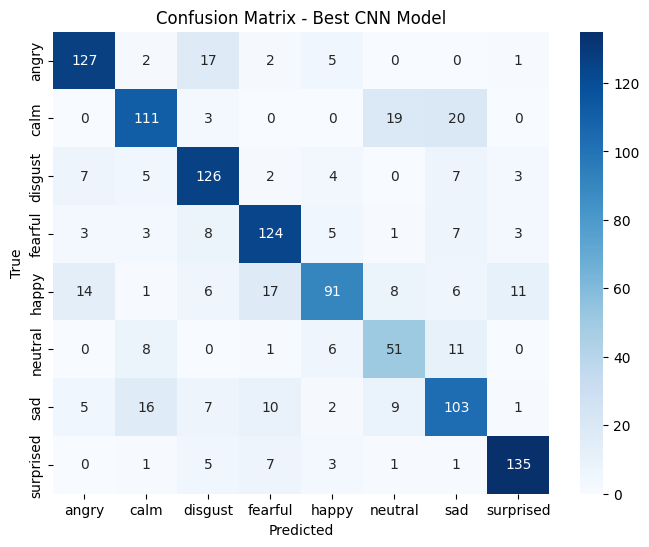

In [65]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Best CNN Model")
plt.show()

In [67]:
# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))



📊 Classification Report:

              precision    recall  f1-score   support

       angry       0.81      0.82      0.82       154
        calm       0.76      0.73      0.74       153
     disgust       0.73      0.82      0.77       154
     fearful       0.76      0.81      0.78       154
       happy       0.78      0.59      0.67       154
     neutral       0.57      0.66      0.61        77
         sad       0.66      0.67      0.67       153
   surprised       0.88      0.88      0.88       153

    accuracy                           0.75      1152
   macro avg       0.75      0.75      0.74      1152
weighted avg       0.76      0.75      0.75      1152



## The final CNN model with data augmentation and class weighting achieved an overall test accuracy of 75%. The confusion matrix and classification report reveal strong performance for emotions such as surprised (F1 = 0.88) and angry (F1 = 0.82), while happy and neutral were more challenging to classify accurately, likely due to overlapping acoustic features with other emotions.

## These results are consistent with the limitations of the RAVDESS dataset, where subtle differences between certain emotions can be difficult to capture from audio alone. Nevertheless, the model demonstrates robust performance and provides a solid baseline for speech emotion recognition.

## Further work could focus on combining additional audio features (e.g., chroma, spectral contrast), using larger datasets, or incorporating multimodal cues (such as facial expressions) to improve accuracy beyond the current benchmark.

## Testing the model

In [80]:
from tensorflow.keras.models import load_model
import pickle
import numpy as np
import librosa

# Load model + encoder
model = load_model(r"C:\Users\USER\Downloads\Emotional_Speech_Recognition\best_cnn_emotion_model.keras")
with open(r"C:\Users\USER\Downloads\Emotional_Speech_Recognition\label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Test on one RAVDESS file
file_path = r"C:\Users\USER\Downloads\Emotional_Speech_Recognition\audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav" 
audio, sr = librosa.load(file_path, sr=16000, mono=True, duration=4)
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
mfccs = np.pad(mfccs, ((0,0),(0,174-mfccs.shape[1])), mode="constant")
mfccs = mfccs[..., np.newaxis][np.newaxis, ...]

pred = model.predict(mfccs)
print("Prediction:", le.inverse_transform([np.argmax(pred)]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Prediction: ['calm']


In [85]:
print(model.input_shape)


(None, 40, 174, 1)
